In [1]:
import pandas as pd
import numpy as np
import os

ds_path = os.path.join(os.getcwd(), '..', 'data')

df = pd.read_csv(os.path.join(ds_path, 'ds_salaries.csv'), index_col=0)

# Data Cleaning and Feature Creation

In [ ]:
df.head()

In [ ]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

def get_iso_codes() -> pd.DataFrame:
    r = requests.get('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes').text
    soup = BeautifulSoup(r, 'html.parser')
    table = soup.findAll('table', class_ = 'wikitable sortable')
    iso_cc_df = pd.read_html(str(table[0]), header=None)[0]
    iso_cc_df = iso_cc_df.T.reset_index().drop(columns=['level_0']).iloc[[0, 3]].T.reset_index(drop=True).rename(columns={0: "Country Name", 3: "Code"}).iloc[1:, :]
    iso_cc_df.loc[1, :]['Code'] = "AF"
    iso_cc_df.dropna(inplace=True)
    to_drop = iso_cc_df[iso_cc_df['Code'].str.contains("See")].index
    iso_cc_df.drop(to_drop, inplace=True)
    iso_cc_df = iso_cc_df.reset_index(drop=True)
    return iso_cc_df

iso_cc_df = get_iso_codes()

In [ ]:
iso_cc_df.to_csv("iso_cc.csv", index=False)

In [ ]:
df.drop(columns=['salary', 'salary_currency'], inplace=True)

In [ ]:
df['arrangement_type'] = df['remote_ratio'] // 50
df['arrangement_type'] = df['arrangement_type'].astype(int).map({0: 'On-site', 1: 'Hybrid', 2: 'Remote'})
df.drop(columns=['remote_ratio'], inplace=True)

In [ ]:
ds_type = {
    ('data scientist', 'data science'): 'Data Science',
    ('data engineer', 'architect', 'etl'): "Data Engineering",
    ('machine learning', 'ml', 'ai', 'computer vision', 'nlp'): 'Machine Learning and Artificial Intelligence',
    ('data analysis', 'data analyst', 'analyst', 'analytics'): "Data Analysis",
    ('research', ): 'Academe',
    ('head of data', ): 'Head of Data'
}

for i, row in df.iterrows():
    labelled = False
    for titles, field in ds_type.items():
        if any(title in row['job_title'].lower() for title in titles):
            df.at[i, 'field'] = field
            labelled = True
            break
    if not labelled:
        df.at[i, 'field'] = 'Other'

df.head()

In [ ]:
df = df[df['field'] != 'Other']

In [ ]:
df['work_year'] = df['work_year'].astype(object)

In [ ]:
df['brain_drain'] = df['employee_residence'] != df['company_location']
df['brain_drain'] = df['brain_drain'].map({True: 'Yes', False: 'No'})

In [ ]:
df.to_csv(os.path.join(ds_path, 'ds_salaries_processed.csv'), index=False)

# Getting to know the Dataset

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_count_plot(df, x):
    plt.figure()
    counts = df[x].value_counts()
    sns.barplot(x=counts.values, y=counts.index)
    plt.title(f"Count Plot of {x}")
    plt.show()

def create_hist_plot(df, x):
    plt.figure()
    sns.histplot(x=df[x])
    plt.title(f"Histogram of {x}")
    plt.show()

In [2]:
analysis_df = pd.read_csv(os.path.join(ds_path, 'ds_salaries_processed.csv'))
analysis_df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,company_location,company_size,arrangement_type,field,brain_drain
0,2020,MI,FT,Data Scientist,79833,DE,DE,L,On-site,Data Science,No
1,2020,SE,FT,Machine Learning Scientist,260000,JP,JP,S,On-site,Machine Learning and Artificial Intelligence,No
2,2020,SE,FT,Big Data Engineer,109024,GB,GB,M,Hybrid,Data Engineering,No
3,2020,MI,FT,Product Data Analyst,20000,HN,HN,S,On-site,Data Analysis,No
4,2020,SE,FT,Machine Learning Engineer,150000,US,US,L,Hybrid,Machine Learning and Artificial Intelligence,No


In [ ]:
create_count_plot(analysis_df, 'experience_level')

In [ ]:
create_count_plot(analysis_df, 'employment_type')

In [ ]:
create_count_plot(analysis_df, 'job_title')

In [ ]:
create_hist_plot(analysis_df, 'salary_in_usd')

In [ ]:
create_count_plot(analysis_df, 'company_size')

In [ ]:
create_count_plot(analysis_df, 'arrangement_type')

In [ ]:
create_count_plot(analysis_df, 'field')

In [ ]:
create_count_plot(analysis_df, 'brain_drain')

# Simple Questions

In [ ]:
from sklearn.preprocessing import PowerTransformer

# How does Mean of Data Science Salaries changed over the years? per field?
temp_df = analysis_df.copy()

# Remove Outlier
to_remove = temp_df[((temp_df['field'] == 'Academe') & (temp_df['salary_in_usd'] > 250000)) | ((temp_df['field'] == 'Data Engineering') & (temp_df['salary_in_usd'] > 200000))]
temp_df = temp_df.drop(to_remove.index)

pt = PowerTransformer()
temp_df['salary_in_usd'] = pt.fit_transform(temp_df['salary_in_usd'].values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20, 18), ncols=2, nrows=2)

fig.subplots_adjust(hspace=0.3, wspace=0.7)

for i, exp_lvl in enumerate(temp_df['experience_level'].unique()):
    curr_ax = ax[i//2, i%2]

    curr_df = temp_df[temp_df['experience_level'] == exp_lvl]
    q1_curr = curr_df.groupby(['work_year', 'field']).mean().sort_values(by=['work_year', 'salary_in_usd'], ascending=[True, True]).reset_index()
    pivot_curr = q1_curr.pivot(index='field', columns='work_year').fillna(-4)

    sns.heatmap(pivot_curr, cmap='Blues', ax=curr_ax, center=0.0)
    curr_ax.set_title(f"Experience Level: {exp_lvl}")
    curr_ax.set_xlabel("")
    curr_ax.set_ylabel("")

plt.suptitle("Salaries of Data Science Jobs by Experience Level per field over the years", fontsize=30)
plt.savefig("q1.jpg", transparent=False)
plt.show()

In [ ]:
# What is the Mean Salary of Data Science Professionals per experience per year

analysis_df.groupby(['experience_level', 'field']).mean().sort_values(by=['experience_level', 'salary_in_usd'], ascending=[True, True])[['salary_in_usd']]

In [ ]:
# Which Countries Experience Brain Drain?

bd_df = analysis_df[analysis_df['brain_drain']=="Yes"].groupby(['employee_residence']).count().sort_values(by='brain_drain', ascending=False)[['brain_drain']]
bd_df.head()
bd_df['brain_drain'] = round((bd_df['brain_drain'] / bd_df['brain_drain'].sum()) * 100, 2)
bd_df

# Markov Chain Analysis

In [74]:
import networkx as nx

def create_graph_dict(df):
    init_residence = dict(zip(df['employee_residence'].unique(), [dict() for i in range(df['employee_residence'].nunique())]))
    for i, row in df.iterrows():
        if row['company_location'] in init_residence[row['employee_residence']]:
            init_residence[row['employee_residence']][row['company_location']] += 1
        else:
            init_residence[row['employee_residence']][row['company_location']] = 1

    to_delete = []
    residence_seqs = {}
    for employee_residence, counts in init_residence.items():
        total_cnts = sum(counts.values())

        if total_cnts == 1:
            to_delete.append(employee_residence)

        for country, count in counts.items():
            counts[country] = count / total_cnts
        residence_seqs[employee_residence] = counts

    return residence_seqs


def create_reverse_graph_dict(df):
    init_residence = dict(zip(df['company_location'].unique(), [dict() for i in range(df['company_location'].nunique())]))
    for i, row in df.iterrows():
        if row['employee_residence'] in init_residence[row['company_location']]:
            init_residence[row['company_location']][row['employee_residence']] += 1
        else:
            init_residence[row['company_location']][row['employee_residence']] = 1

    to_delete = []
    residence_seqs = {}
    for employee_residence, counts in init_residence.items():
        total_cnts = sum(counts.values())

        if total_cnts == 1:
            to_delete.append(employee_residence)

        for country, count in counts.items():
            counts[country] = count / total_cnts
        residence_seqs[employee_residence] = counts

    return residence_seqs


def graph_network(graph_dict, residence, title, reversed=False):
        fig = plt.figure(figsize=(6, 6))

        G = nx.Graph()
        destinations = graph_dict[residence]
        edge_labels = {}
        for i, (country, prob) in enumerate(destinations.items()):
            G.add_edge(residence, country, weight=prob )
            edge_labels[(residence, country)] = prob

        node_sizes = []
        node_colors = []
        for u, ddict in G.nodes(data=True):
            if u == residence:
                node_colors.append('r')
            else:
                node_colors.append('b')
            node_sizes.append(500)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, font_color='white', with_labels=True)
        for u, v, ddict in G.edges(data=True):
            node1_x, node1_y = pos[u]
            node2_x, node2_y = pos[v]
            x_mid = (node1_x + node2_x) / 2
            y_mid = (node1_y + node2_y) / 2
            plt.text(x_mid, y_mid, str(round(ddict['weight'],4)), bbox=dict(facecolor='white', edgecolor='black'), ha='center', va='center')
        
        plt.title(title)

        return fig

def graph_reverse_network(graph_dict, residence, title):
        fig = plt.figure(figsize=(6, 6))

        G = nx.Graph()
        destinations = graph_dict[residence]
        edge_labels = {}
        for i, (country, prob) in enumerate(destinations.items()):
            G.add_edge(country, residence, weight=prob )
            edge_labels[(country, residence)] = prob

        node_sizes = []
        node_colors = []
        for u, ddict in G.nodes(data=True):
            if u == residence:
                node_colors.append('r')
            else:
                node_colors.append('b')
            node_sizes.append(500)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, font_color='white', with_labels=True)
        for u, v, ddict in G.edges(data=True):
            node1_x, node1_y = pos[u]
            node2_x, node2_y = pos[v]
            x_mid = (node1_x + node2_x) / 2
            y_mid = (node1_y + node2_y) / 2
            plt.text(x_mid, y_mid, str(round(ddict['weight'],4)), bbox=dict(facecolor='white', edgecolor='black'), ha='center', va='center')
        
        plt.title(title)

        return fig



def graph_top5_origin(df):
    top5_countries = df.groupby(['company_location']).count()['employee_residence'].sort_values(ascending=False).head(5)
    for country in top5_countries.index:
        graph_network(create_graph_dict(df), country, f"Markov Chain of Data Scientist Migration from {country}")
    return create_graph_dict(df)

def graph_top5_destination(df):
    top5_countries = df.groupby(['employee_residence']).count()['company_location'].sort_values(ascending=False).head(5)
    for country in top5_countries.index:
        graph_network(create_reverse_graph_dict(df), country, f"Markov Chain of Data Scientist Migration to {country}")
    return create_reverse_graph_dict(df)

def graph_top5_destination_with_decay(df):
    top5_countries = df.groupby(['employee_residence']).count()['company_location'].sort_values(ascending=False).head(5)
    for year in [2020, 2021, 2022]:
        for country in top5_countries.index:
            graph_network(create_reverse_graph_dict(df[df['work_year']==year]), country, f"Markov Chain of Data Scientist Migration to {country} for year {year}")
    return create_reverse_graph_dict(df)

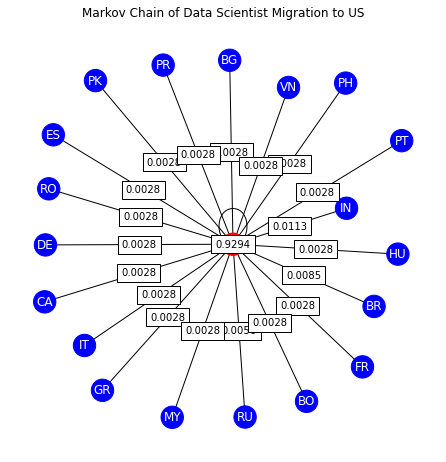

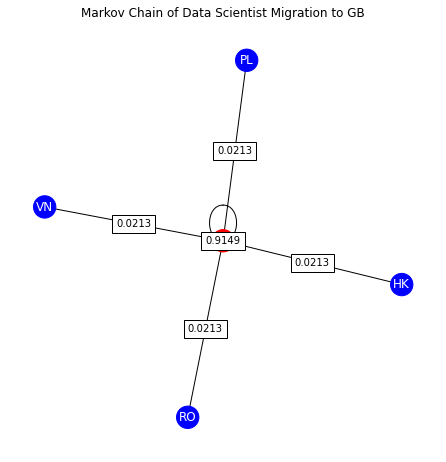

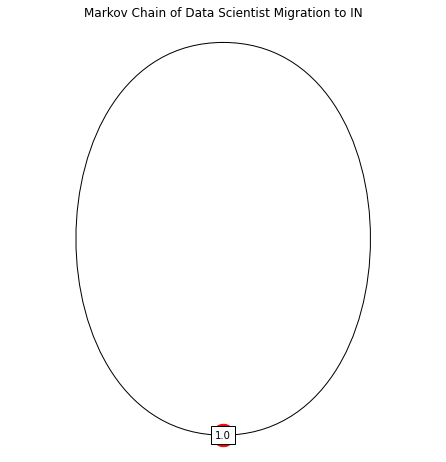

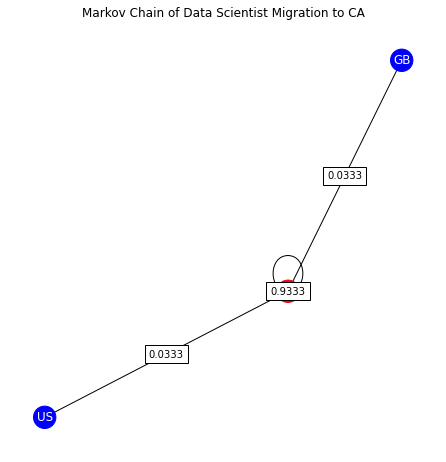

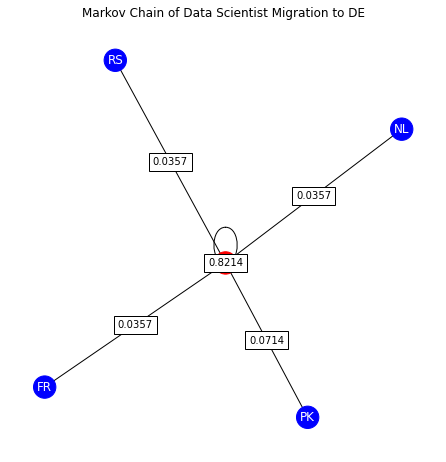

In [76]:
rgd = graph_top5_destination(analysis_df)

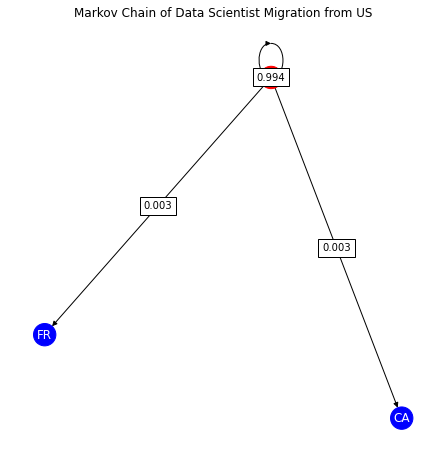

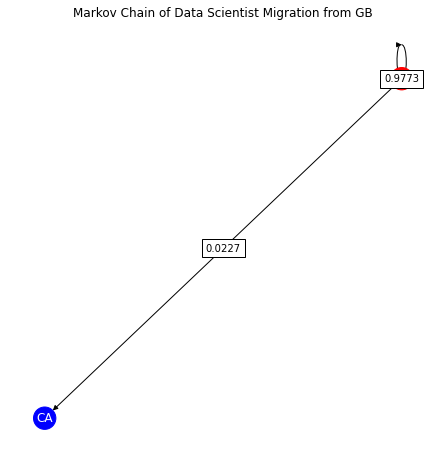

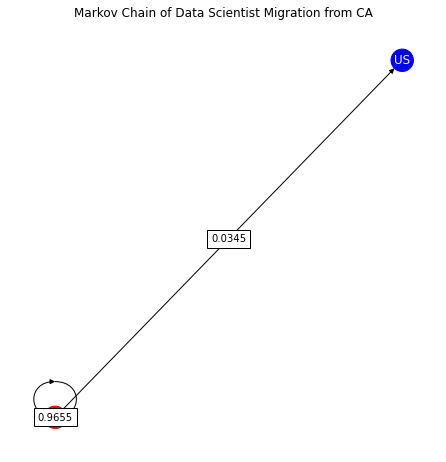

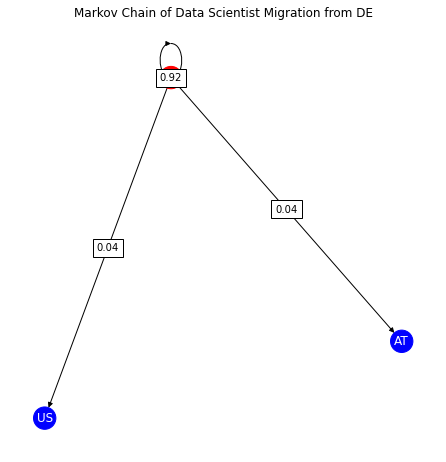

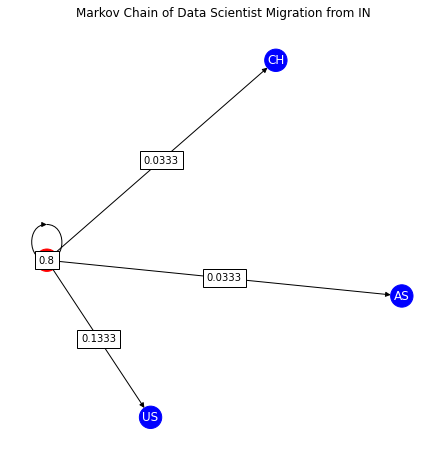

In [9]:
gd = graph_top5_origin(analysis_df)

# Test with Human Development Index

In [24]:
# https://worldpopulationreview.com/country-rankings/third-world-countries

iso_cc_with_human_dev_and_pop = pd.read_csv(os.path.join(ds_path, "iso_cc_with_human_dev_and_pop.csv"))
iso_cc_with_human_dev_and_pop

,Country Name,Code,country,humanDevelopmentIndex,pop2022
0,Afghanistan,AF,Afghanistan,0.498,40754388.0
1,Åland Islands,AX,NaN,NaN,NaN
2,Albania,AL,Albania,0.785,2866374.0
3,Algeria,DZ,Algeria,0.754,45350148.0
4,American Samoa,AS,NaN,NaN,NaN
...,...,...,...,...,...
244,Wallis and Futuna,WF,NaN,NaN,NaN
245,Western Sahara [ah],EH,NaN,NaN,NaN
246,Yemen,YE,Yemen,0.452,31154867.0
247,Zambia,ZM,Zambia,0.588,19470234.0


In [31]:
gd = pd.DataFrame(gd).fillna(0)

In [32]:
gd

,DE,JP,GB,HN,US,HU,NZ,FR,IN,PK,...,CZ,AR,DZ,TN,MY,EE,AU,BO,IE,CH
DE,0.92,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.055556,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US,0.04,0.000000,0.000000,0.0,0.993958,0.5,0.0,0.055556,0.133333,0.166667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
AT,0.04,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JP,0.00,0.857143,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MY,0.00,0.142857,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GB,0.00,0.000000,0.977273,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA,0.00,0.000000,0.022727,0.0,0.003021,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HN,0.00,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FR,0.00,0.000000,0.000000,0.0,0.003021,0.0,0.0,0.777778,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HU,0.00,0.000000,0.000000,0.0,0.000000,0.5,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def find_prob_stay(row):
    try:
        row['prob_stay'] = gd[row['employee_residence']][row['employee_residence']]
    except KeyError:
        row['prob_stay'] = 0
    return row

merged_df = analysis_df.merge(iso_cc_with_human_dev_and_pop, left_on='employee_residence', how='left', right_on='Code')
merged_df = merged_df.merge(iso_cc_with_human_dev_and_pop, left_on='company_location', how='left', right_on='Code', suffixes=("_Origin", "_Destination"))
merged_df = merged_df.apply(find_prob_stay, axis=1)
merged_df['HumanDevIdx_Diff'] = merged_df['humanDevelopmentIndex_Destination'] - merged_df['humanDevelopmentIndex_Origin']
merged_df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,company_location,company_size,arrangement_type,field,...,country_Origin,humanDevelopmentIndex_Origin,pop2022_Origin,Country Name_Destination,Code_Destination,country_Destination,humanDevelopmentIndex_Destination,pop2022_Destination,prob_stay,HumanDevIdx_Diff
0,2020,MI,FT,Data Scientist,79833,DE,DE,L,On-site,Data Science,...,Germany,0.936,8.388360e+07,Germany,DE,Germany,0.936,8.388360e+07,0.920000,0.0
1,2020,SE,FT,Machine Learning Scientist,260000,JP,JP,S,On-site,Machine Learning and Artificial Intelligence,...,Japan,0.909,1.255848e+08,Japan,JP,Japan,0.909,1.255848e+08,0.857143,0.0
2,2020,SE,FT,Big Data Engineer,109024,GB,GB,M,Hybrid,Data Engineering,...,United Kingdom,0.920,6.849791e+04,United Kingdom of Great Britain and Northern I...,GB,United Kingdom,0.920,6.849791e+04,0.977273,0.0
3,2020,MI,FT,Product Data Analyst,20000,HN,HN,S,On-site,Data Analysis,...,Honduras,0.617,1.022125e+07,Honduras,HN,Honduras,0.617,1.022125e+07,1.000000,0.0
4,2020,SE,FT,Machine Learning Engineer,150000,US,US,L,Hybrid,Machine Learning and Artificial Intelligence,...,United States,0.920,3.348053e+05,United States of America (the),US,United States,0.920,3.348053e+05,0.993958,0.0


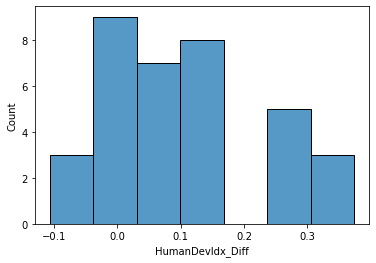

In [28]:
migrated = merged_df[merged_df['HumanDevIdx_Diff']!=0]

plt.figure()
sns.histplot(migrated['HumanDevIdx_Diff'])
plt.show()

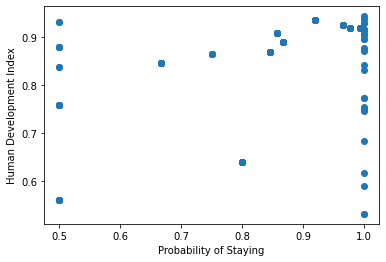

In [29]:
non_migrated = merged_df[merged_df['prob_stay']>0.01]

plt.figure()
plt.scatter(non_migrated['prob_stay'], non_migrated['humanDevelopmentIndex_Origin'])
plt.xlabel('Probability of Staying')
plt.ylabel('Human Development Index')
plt.show()

In [23]:
non_migrated[(non_migrated['humanDevelopmentIndex_Origin'] > 0.9) & (non_migrated['prob_stay'] < 0.1)]['prob_stay']

82     0.022727
99     0.040000
199    0.040000
487    0.034483
Name: prob_stay, dtype: float64

# Conclusions

# Recommendations for Future Studies